Tutorial 4: Why Modeling Is Hard
================================

We have successfully fitted a simple 1D Gaussian profile to a dataset using a non-linear search. While achieving an
accurate model fit has been straightforward, the reality is that model fitting is a challenging problem where many things can go wrong.

This tutorial will illustrate why modeling is challenging, highlight common problems that occur when fitting complex
models, and show how a good scientific approach can help us overcome these challenges.

We will build on concepts introduced in previous tutorials, such as the non-linear parameter space, likelihood surface,
and the role of priors.

__Overview__

In this tutorial, we will fit complex models with up to 15 free parameters and consider the following:

- Why more complex models are more difficult to fit and may lead the non-linear search to infer an incorrect solution.

- Strategies for ensuring the non-linear search estimates the correct solution.

- What drives the run-times of a model fit and how to carefully balance run-times with model complexity.

__Contents__

- **Data**: Load and plot the 1D Gaussian dataset we'll fit, which is more complex than the previous tutorial.
- **Model**: The `Gaussian` model component that we will fit to the data.
- **Analysis**: The log likelihood function used to fit the model to the data.
- **Collection**: The `Collection` model used to compose the model-fit.
- **Model Fit**: Perform the model-fit and examine the results.
- **Result**: Determine if the model-fit was successful and what can be done to ensure a good model-fit.
- **Why Modeling is Hard**: Introduce the concept of randomness and local maxima and why they make model-fitting challenging.
- **Prior Tuning**: Adjust the priors of the model to help the non-linear search find the global maxima solution.
- **Reducing Complexity**: Simplify the model to reduce the dimensionality of the parameter space.
- **Search More Thoroughly**: Adjust the non-linear search settings to search parameter space more thoroughly.
- **Run Times**: Discuss how the likelihood function and complexity of a model impacts the run-time of a model-fit.
- **Model Mismatches**: Introduce the concept of model mismatches and how it makes inferring the correct model challenging.
- **Astronomy Example**: How the concepts of this tutorial are applied to real astronomical problems.
- **Wrap Up**: A summary of the key takeaways of this tutorial.

In [1]:
%matplotlib inline
from pyprojroot import here
workspace_path = str(here())
%cd $workspace_path
print(f"Working Directory has been set to `{workspace_path}`")

from os import path
import numpy as np
import matplotlib.pyplot as plt

import autofit as af

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.
/mnt/c/Users/Jammy/Code/PyAuto/stfc_data_summer_school_2024_2
Working Directory has been set to `/mnt/c/Users/Jammy/Code/PyAuto/stfc_data_summer_school_2024_2`


__Data__

Load the dataset we fit. 

This is a new `dataset` where the underlying signal is a sum of five `Gaussian` profiles.

In [2]:
dataset_path = path.join("dataset", "example_1d", "gaussian_x5")
data = af.util.numpy_array_from_json(file_path=path.join(dataset_path, "data.json"))
noise_map = af.util.numpy_array_from_json(
    file_path=path.join(dataset_path, "noise_map.json")
)

Plotting the data reveals that the signal is more complex than a simple 1D Gaussian, as the wings to the left and 
right are more extended than what a single Gaussian profile can account for.

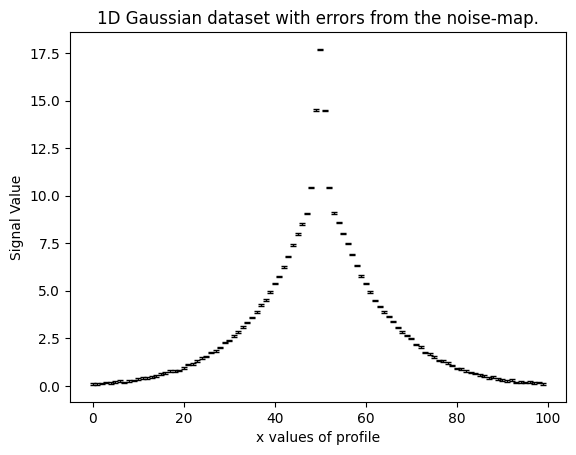

In [3]:
xvalues = np.arange(data.shape[0])
plt.errorbar(
    xvalues,
    data,
    yerr=noise_map,
    linestyle="",
    color="k",
    ecolor="k",
    elinewidth=1,
    capsize=2,
)
plt.title("1D Gaussian dataset with errors from the noise-map.")
plt.xlabel("x values of profile")
plt.ylabel("Signal Value")
plt.show()
plt.clf()
plt.close()

__Model__

Create the `Gaussian` class from which we will compose model components using the standard format.

In [4]:


class Gaussian:
    def __init__(
        self,
        centre: float = 30.0,  # <- **PyAutoFit** recognises these constructor arguments
        normalization: float = 1.0,  # <- are the Gaussian`s model parameters.
        sigma: float = 5.0,
    ):
        """
        Represents a 1D Gaussian profile.

        This is a model-component of example models in the **HowToFit** lectures and is used to perform model-fitting
        of example datasets.

        Parameters
        ----------
        centre
            The x coordinate of the profile centre.
        normalization
            Overall normalization of the profile.
        sigma
            The sigma value controlling the size of the Gaussian.
        """
        self.centre = centre
        self.normalization = normalization
        self.sigma = sigma

    def model_data_from(self, xvalues: np.ndarray) -> np.ndarray:
        """
        Returns a 1D Gaussian on an input list of Cartesian x coordinates.

        The input xvalues are translated to a coordinate system centred on the Gaussian, via its `centre`.

        The output is referred to as the `model_data` to signify that it is a representation of the data from the
        model.

        Parameters
        ----------
        xvalues
            The x coordinates in the original reference frame of the data.

        Returns
        -------
        np.array
            The Gaussian values at the input x coordinates.
        """
        transformed_xvalues = np.subtract(xvalues, self.centre)
        return np.multiply(
            np.divide(self.normalization, self.sigma * np.sqrt(2.0 * np.pi)),
            np.exp(-0.5 * np.square(np.divide(transformed_xvalues, self.sigma))),
        )


__Analysis__

To define the Analysis class for this model-fit, we need to ensure that the `log_likelihood_function` can handle an 
instance containing multiple 1D profiles. Below is an expanded explanation and the corresponding class definition:

The log_likelihood_function will now assume that the instance it receives consists of multiple Gaussian profiles. 
For each Gaussian in the instance, it will compute the model_data and then sum these to create the overall `model_data` 
that is compared to the observed data.

In [5]:


class Analysis(af.Analysis):
    def __init__(self, data: np.ndarray, noise_map: np.ndarray):
        """
        The `Analysis` class acts as an interface between the data and model in **PyAutoFit**.

        Its `log_likelihood_function` defines how the model is fitted to the data and it is called many times by
        the non-linear search fitting algorithm.

        In this example, the `log_likelihood_function` receives an instance containing multiple instances of
        the `Gaussian` class and sums the `model_data` of each to create the overall model fit to the data.

        In this example the `Analysis` `__init__` constructor only contains the `data` and `noise-map`, but it can be
        easily extended to include other quantities.

        Parameters
        ----------
        data
            A 1D numpy array containing the data (e.g. a noisy 1D signal) fitted in the workspace examples.
        noise_map
            A 1D numpy array containing the noise values of the data, used for computing the goodness of fit
            metric, the log likelihood.
        """
        super().__init__()

        self.data = data
        self.noise_map = noise_map

    def log_likelihood_function(self, instance) -> float:
        """
        Returns the log likelihood of a fit of a 1D Gaussian to the dataset.

        In the previous tutorial, the instance was a single `Gaussian` profile, however this function now assumes
        the instance contains multiple `Gaussian` profiles.

        The `model_data` is therefore the summed `model_data` of all individual Gaussians in the model.

        The docstring below describes this in more detail.

        Parameters
        ----------
        instance
            A list of 1D profiles with parameters set via the non-linear search.

        Returns
        -------
        float
            The log likelihood value indicating how well this model fit the `MaskedDataset`.
        """

        """
        In the previous tutorial the instance was a single `Gaussian` profile, meaning we could create the model data 
        using the line:

            model_data = instance.gaussian.model_data_from(xvalues=self.data.xvalues)

        In this tutorial our instance is comprised of three 1D Gaussians, because we will use a `Collection` to
        compose the model:

            model = Collection(gaussian_0=Gaussian, gaussian_1=Gaussian, gaussian_2=Gaussian).

        By using a Collection, this means the instance parameter input into the fit function is a
        dictionary where individual profiles (and their parameters) can be accessed as followed:

            print(instance.gaussian_0)
            print(instance.gaussian_1)
            print(instance.gaussian_2)
            
            print(instance.gaussian_0.centre)
            print(instance.gaussian_1.centre)
            print(instance.gaussian_2.centre)

        The `model_data` is therefore the summed `model_data` of all individual Gaussians in the model. 
        
        The function `model_data_from_instance` performs this summation. 
        """
        model_data = self.model_data_from_instance(instance=instance)

        residual_map = self.data - model_data
        chi_squared_map = (residual_map / self.noise_map) ** 2.0
        chi_squared = sum(chi_squared_map)
        noise_normalization = np.sum(np.log(2 * np.pi * noise_map**2.0))
        log_likelihood = -0.5 * (chi_squared + noise_normalization)

        return log_likelihood

    def model_data_from_instance(self, instance):
        """
        To create the summed profile of all individual profiles, we use a list comprehension to iterate over
        all profiles in the instance.

        The `instance` has the properties of a Python `iterator` and therefore can be looped over using the standard
        Python for syntax (e.g. `for profile in instance`).

        __Alternative Syntax__

        For those not familiar with Python list comprehensions, the code below shows how to use the instance to
        create the summed profile using a for loop and numpy array:

        model_data = np.zeros(shape=self.data.xvalues.shape[0])

        for profile in instance:
            model_data += profile.model_data_from(xvalues=self.data.xvalues)

        return model_data
        """
        xvalues = np.arange(self.data.shape[0])

        return sum([profile.model_data_from(xvalues=xvalues) for profile in instance])


__Collection__

In the previous tutorial, we fitted a single `Gaussian` profile to the dataset by turning it into a model 
component using the `Model` class.

In this tutorial, we will fit a model composed of five `Gaussian` profiles. To do this, we need to combine 
five `Gaussian` model components into a single model.

This can be achieved using a `Collection` object, which was introduced in tutorial 1. The `Collection` object allows 
us to group together multiple model components—in this case, five `Gaussian` profiles—into one model that can be 
passed to the non-linear search.

In [6]:
model = af.Collection(
    gaussian_0=Gaussian,
    gaussian_1=Gaussian,
    gaussian_2=Gaussian,
    gaussian_3=Gaussian,
    gaussian_4=Gaussian,
)

The `model.info` confirms the model is composed of 5 `Gaussian` profiles.

In [7]:
print(model.info)

Total Free Parameters = 15

model                                                                           Collection (N=15)
    gaussian_0 - gaussian_4                                                     Gaussian (N=3)

gaussian_0
    centre                                                                      UniformPrior [0], lower_limit = 0.0, upper_limit = 100.0
    normalization                                                               LogUniformPrior [1], lower_limit = 1e-06, upper_limit = 1000000.0
    sigma                                                                       UniformPrior [2], lower_limit = 0.0, upper_limit = 25.0
gaussian_1
    centre                                                                      UniformPrior [3], lower_limit = 0.0, upper_limit = 100.0
    normalization                                                               LogUniformPrior [4], lower_limit = 1e-06, upper_limit = 1000000.0
    sigma                                             

__Search__

We again use the nested sampling algorithm Dynesty to fit the model to the data.

In [8]:
search = af.DynestyStatic(
    sample="rwalk",  # This makes dynesty run faster, don't worry about what it means for now!
)

__Model Fit__

Perform the fit using our five `Gaussian` model, which has 15 free parameters.

This means the non-linear parameter space has a dimensionality of N=15, making it significantly more complex 
than the simpler model we fitted in the previous tutorial.

Consequently, the non-linear search takes slightly longer to run but still completes in under a minute.

In [9]:
analysis = Analysis(data=data, noise_map=noise_map)

print(
    """
    The non-linear search has begun running.
    This Jupyter notebook cell with progress once the search has completed - this could take a few minutes!
    """
)

result = search.fit(model=model, analysis=analysis)

print("The search has finished run - you may now continue the notebook.")


    The non-linear search has begun running.
    This Jupyter notebook cell with progress once the search has completed - this could take a few minutes!
    
2024-07-16 13:59:02,302 - autofit.non_linear.search.abstract_search - INFO - Starting non-linear search with 1 cores.
2024-07-16 13:59:02,305 - root - INFO - Output to hard-disk disabled, input a search name to enable.
2024-07-16 13:59:02,306 - root - INFO - Starting new Dynesty non-linear search (no previous samples found).
2024-07-16 13:59:02,371 - autofit.non_linear.parallel.sneaky - INFO - Creating pool with 1 processes
2024-07-16 13:59:02,386 - process 0 - INFO - created
2024-07-16 13:59:02,426 - autofit.non_linear.initializer - INFO - Generating initial samples of model using 1 cores
2024-07-16 13:59:02,718 - autofit.non_linear.initializer - INFO - Initial samples generated, starting non-linear search


3811it [00:23, 165.26it/s, +50 | bound: 482 | nc: 1 | ncall: 20032 | eff(%): 19.322 | loglstar:   -inf < 126.983 <    inf | logz: 52.945 +/-  0.999 | dlogz:  0.001 >  0.059]    


2024-07-16 13:59:27,181 - root - INFO - Search complete, returning result
The search has finished run - you may now continue the notebook.


__Result__

The `info` attribute shows the result in a readable format, which contains information on the full collection
of all 5 model components.

In [10]:
print(result.info)

Bayesian Evidence                                                               52.94514906
Maximum Log Likelihood                                                          126.98329498
Maximum Log Posterior                                                           1175714.83943277

model                                                                           Collection (N=15)
    gaussian_0 - gaussian_4                                                     Gaussian (N=3)

Maximum Log Likelihood Model:

gaussian_0
    centre                                                                      69.772
    normalization                                                               0.000
    sigma                                                                       0.650
gaussian_1
    centre                                                                      25.090
    normalization                                                               0.000
    sigma                             

From the result info, it is hard to assess if the model fit was good or not.

A good way to evaluate the fit is through a visual inspection of the model data plotted over the actual data.

If the model data (red line) consistently aligns with the data points (black error bars), the fit is good. 
However, if the model misses certain features of the data, such as peaks or regions of high intensity, 
the fit was not successful.

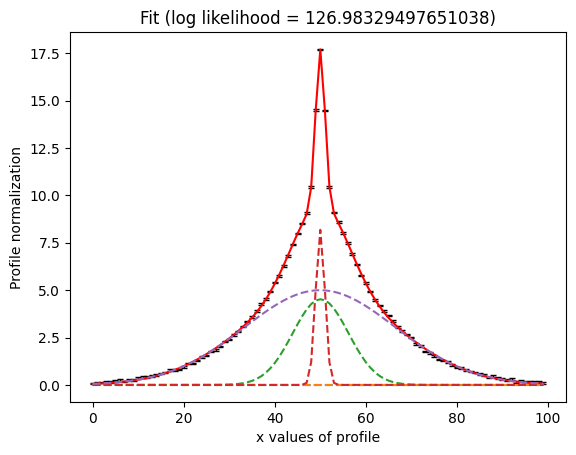

In [11]:
instance = result.max_log_likelihood_instance

model_data_0 = instance.gaussian_0.model_data_from(xvalues=np.arange(data.shape[0]))
model_data_1 = instance.gaussian_1.model_data_from(xvalues=np.arange(data.shape[0]))
model_data_2 = instance.gaussian_2.model_data_from(xvalues=np.arange(data.shape[0]))
model_data_3 = instance.gaussian_3.model_data_from(xvalues=np.arange(data.shape[0]))
model_data_4 = instance.gaussian_4.model_data_from(xvalues=np.arange(data.shape[0]))

model_data_list = [model_data_0, model_data_1, model_data_2, model_data_3, model_data_4]

model_data = sum(model_data_list)

plt.errorbar(
    x=xvalues,
    y=data,
    yerr=noise_map,
    linestyle="",
    color="k",
    ecolor="k",
    elinewidth=1,
    capsize=2,
)
plt.plot(range(data.shape[0]), model_data, color="r")
for model_data_1d_individual in model_data_list:
    plt.plot(range(data.shape[0]), model_data_1d_individual, "--")
plt.title(f"Fit (log likelihood = {result.log_likelihood})")
plt.xlabel("x values of profile")
plt.ylabel("Profile normalization")
plt.savefig("fit.png")
plt.show()
plt.close()

It's challenging to determine from the plot whether the data and model data perfectly overlap across the entire dataset.

To clarify this, the residual map introduced in tutorial 2 is useful. It provides a clear representation of where 
the differences between the model and data exceed the noise level.

Regions where the black error bars do not align with the zero line in the residual map indicate areas where the model 
did not fit the data well and is inconsistent with the data above the noise level. Furthermore, regions where
larger values of residuals are next to one another indicate that the model failed to accurate fit that
region of the data.

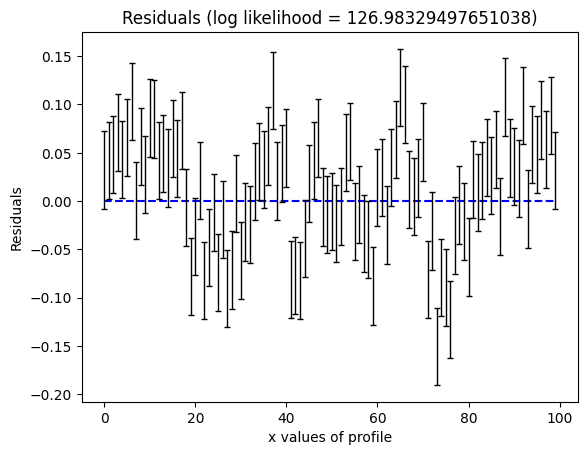

In [12]:
residual_map = data - model_data
plt.plot(range(data.shape[0]), np.zeros(data.shape[0]), "--", color="b")
plt.errorbar(
    x=xvalues,
    y=residual_map,
    yerr=noise_map,
    color="k",
    ecolor="k",
    elinewidth=1,
    capsize=2,
    linestyle="",
)
plt.title(f"Residuals (log likelihood = {result.log_likelihood})")
plt.xlabel("x values of profile")
plt.ylabel("Residuals")
plt.savefig("residual_map.png")
plt.show()
plt.clf()
plt.close()

The normalized residual map, as discussed in tutorial 2, provides an alternative visualization of the fit quality.

Normalized residuals indicate the standard deviation (σ) level at which the residuals could have been drawn from the 
noise. For instance, a normalized residual of 2.0 suggests that a residual value is 2.0σ away from the noise, 
implying there is a 5% chance such a residual would occur due to noise.

Values of normalized residuals above 3.0 are particularly improbable (occurring only 0.3% of the time), which is 
generally considered a threshold where issues with the model-fit are likely the cause of the residual as opposed
to it being a noise fluctuation.

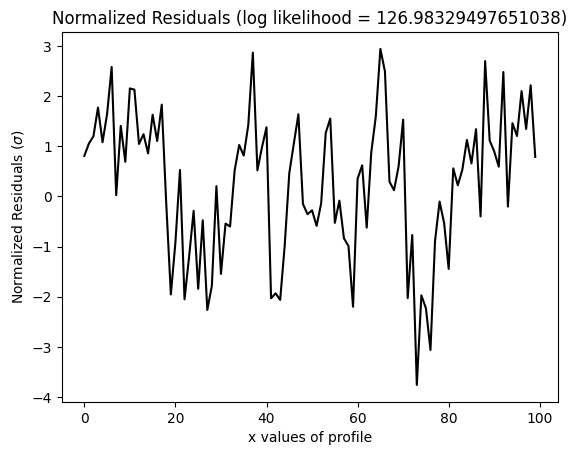

In [13]:
residual_map = data - model_data
normalized_residual_map = residual_map / noise_map
plt.plot(xvalues, normalized_residual_map, color="k")
plt.title(f"Normalized Residuals (log likelihood = {result.log_likelihood})")
plt.xlabel("x values of profile")
plt.ylabel("Normalized Residuals ($\sigma$)")
plt.savefig("normalized_residual_map.png")
plt.show()
plt.clf()
plt.close()

So, did you achieve a good fit? Maybe a bad one? Or just an okay one?

The truth is, I don't know, and I can't tell you for sure. Modeling is inherently random. It's not uncommon to 
fit the same model to the same dataset using the same non-linear search and get a different result each time.

When I ran the model fit above, that's exactly what happened. It produced a range of fits: some bad, some okay, and 
some good, as shown in the images below:

<table><tr>
<td> <img src="https://github.com/Jammy2211/autofit_workspace/blob/main/scripts/howtofit/chapter_1_introduction/images/bad_fit.png?raw=true" width="400" height="400"></td>
<td> <img src="https://github.com/Jammy2211/autofit_workspace/blob/main/scripts/howtofit/chapter_1_introduction/images/okay_fit.png?raw=true" width="400" height="400">  </td>
<td> <img src="https://github.com/Jammy2211/autofit_workspace/blob/main/scripts/howtofit/chapter_1_introduction/images/good_fit.png?raw=true" width="400" height="400"> </td>
</tr></table>

Distinguishing between the good and okay fit is difficult, however the normalized residuals make this easier. They show
that for the okay fit there are residuals above 3.0 sigma, indicating that the model did not perfectly fit the data.

<table><tr>
<td> <img src="https://github.com/Jammy2211/autofit_workspace/blob/main/scripts/howtofit/chapter_1_introduction/images/bad_normalized_residual_map.png?raw=true" width="400" height="400"></td>
<td> <img src="https://github.com/Jammy2211/autofit_workspace/blob/main/scripts/howtofit/chapter_1_introduction/images/okay_normalized_residual_map.png?raw=true" width="400" height="400">  </td>
<td> <img src="https://github.com/Jammy2211/autofit_workspace/blob/main/scripts/howtofit/chapter_1_introduction/images/good_normalized_residual_map.png?raw=true" width="400" height="400"> </td>
</tr></table>

You should quickly rerun the code above a couple of times to see this variability for yourself.

__Why Modeling is Hard__

This variability is at the heart of why modeling is challenging. The process of model-fitting is stochastic, 
meaning it's hard as the scientist to determine if a better fit is possible or not.

Why does modeling produce different results each time, and why might it sometimes infer solutions that are not good fits?

In the previous tutorial, the non-linear search consistently found models that visually matched the data well, 
minimizing residuals and yielding high log likelihood values. These optimal solutions are called 'global maxima', 
they are where the model parameters correspond to the highest likelihood regions across the entire parameter space. 
This ideal scenario is illustrated in the `good_fit.png` image above.

However, non-linear searches do not always find these global maxima. Instead, they might settle on 'local maxima' 
solutions, which have high log likelihood values relative to nearby models in parameter space but are significantly 
lower than the true global maxima found elsewhere.

This is what happened for the okay and bad fits above. The non-linear search converged on solutions that were locally
peaks on the likelihood surface but were not the global maximum solution. This is why the residuals were higher and
the normalized residuals above 3.0 sigma.

Why does a non-linear search end up at local maxima? As discussed, the search iterates through many models, 
focusing more on regions where previous guesses yielded higher likelihoods. It gradually converges around 
solutions with higher likelihoods compared to surrounding models. If the search isn't exhaustive enough, it might 
converge on a local maxima that appears good compared to nearby models but isn't the global maximum.

Modeling is challenging because the parameter spaces of complex models are typically filled with local maxima, 
making it hard for a non-linear search to locate the global maximum.

Fortunately, there are strategies to help non-linear searches find the global maxima, and we'll now explore three of 
them.

__Prior Tuning__

First, let's assist our non-linear search by tuning our priors. Priors provide guidance to the search on where to 
explore in the parameter space. By setting more accurate priors ('tuning' them), we can help the search find the 
global solution instead of settling for a local maximum.

For instance, from the data itself, it's evident that all `Gaussian` profiles are centered around pixel 50. In our 
previous fit, the `centre` parameter of each `Gaussian` had a `UniformPrior` spanning from 0.0 to 100.0, which is 
much broader than necessary given the data's range.

Additionally, the peak value of the data's `normalization` parameter was around 17.5. This indicates that 
the `normalization` values of our `Gaussians` do not exceed 500.0, allowing us to refine our prior accordingly.

The following code snippet adjusts these priors for the `centre` and `normalization` parameters of 
each `Gaussian` using **PyAutoFit**'s API for model and prior customization:

In [14]:
gaussian_0 = af.Model(Gaussian)

gaussian_0.centre = af.UniformPrior(lower_limit=45.0, upper_limit=55.0)
gaussian_0.normalization = af.LogUniformPrior(lower_limit=0.1, upper_limit=500.0)

gaussian_1 = af.Model(Gaussian)

gaussian_1.centre = af.UniformPrior(lower_limit=45.0, upper_limit=55.0)
gaussian_1.normalization = af.LogUniformPrior(lower_limit=0.1, upper_limit=500.0)

gaussian_2 = af.Model(Gaussian)

gaussian_2.centre = af.UniformPrior(lower_limit=45.0, upper_limit=55.0)
gaussian_2.normalization = af.LogUniformPrior(lower_limit=0.1, upper_limit=500.0)

gaussian_3 = af.Model(Gaussian)

gaussian_3.centre = af.UniformPrior(lower_limit=45.0, upper_limit=55.0)
gaussian_3.normalization = af.LogUniformPrior(lower_limit=0.1, upper_limit=500.0)

gaussian_4 = af.Model(Gaussian)

gaussian_4.centre = af.UniformPrior(lower_limit=45.0, upper_limit=55.0)
gaussian_4.normalization = af.LogUniformPrior(lower_limit=0.1, upper_limit=500.0)

model = af.Collection(
    gaussian_0=gaussian_0,
    gaussian_1=gaussian_1,
    gaussian_2=gaussian_2,
    gaussian_3=gaussian_3,
    gaussian_4=gaussian_4,
)

The `info` attribute shows the model is now using the priors specified above.

In [15]:
print(model.info)

Total Free Parameters = 15

model                                                                           Collection (N=15)
    gaussian_0 - gaussian_4                                                     Gaussian (N=3)

gaussian_0
    centre                                                                      UniformPrior [18], lower_limit = 45.0, upper_limit = 55.0
    normalization                                                               LogUniformPrior [19], lower_limit = 0.1, upper_limit = 500.0
    sigma                                                                       UniformPrior [17], lower_limit = 0.0, upper_limit = 25.0
gaussian_1
    centre                                                                      UniformPrior [23], lower_limit = 45.0, upper_limit = 55.0
    normalization                                                               LogUniformPrior [24], lower_limit = 0.1, upper_limit = 500.0
    sigma                                                    

We now repeat the model-fit using these updated priors.

First, you should note that the run time of the fit is significantly faster than the previous fit. This is because
the prior is telling the non-linear search where to look, meaning it converges on solutions more quickly
and spends less time searching regions of parameter space that do not contain solutions.

Second, the model-fit consistently produces a good model-fit more often, because our tuned priors are centred
on the global maxima solution ensuring the non-linear search is less likely to converge on a local maxima.

In [16]:
print(
    """
    The non-linear search has begun running.
    This Jupyter notebook cell with progress once the search has completed - this could take a few minutes!
    """
)

result = search.fit(model=model, analysis=analysis)

print("The search has finished run - you may now continue the notebook.")


    The non-linear search has begun running.
    This Jupyter notebook cell with progress once the search has completed - this could take a few minutes!
    
2024-07-16 13:59:28,266 - autofit.non_linear.search.abstract_search - INFO - Starting non-linear search with 1 cores.
2024-07-16 13:59:28,267 - root - INFO - Output to hard-disk disabled, input a search name to enable.
2024-07-16 13:59:28,268 - root - INFO - Starting new Dynesty non-linear search (no previous samples found).
2024-07-16 13:59:28,326 - autofit.non_linear.parallel.sneaky - INFO - Creating pool with 1 processes
2024-07-16 13:59:28,340 - process 0 - INFO - created
2024-07-16 13:59:28,379 - autofit.non_linear.initializer - INFO - Generating initial samples of model using 1 cores
2024-07-16 13:59:28,657 - autofit.non_linear.initializer - INFO - Initial samples generated, starting non-linear search


3924it [00:26, 150.17it/s, +50 | bound: 508 | nc: 1 | ncall: 20572 | eff(%): 19.365 | loglstar:   -inf < 188.757 <    inf | logz: 112.755 +/-  1.116 | dlogz:  0.001 >  0.059]


2024-07-16 13:59:56,092 - root - INFO - Search complete, returning result
The search has finished run - you may now continue the notebook.


Lets print the result info and plot the fit to the dataset to confirm the priors have provided a better model-fit.

Bayesian Evidence                                                               112.75477492
Maximum Log Likelihood                                                          188.75680356
Maximum Log Posterior                                                           188.89786175

model                                                                           Collection (N=15)
    gaussian_0 - gaussian_4                                                     Gaussian (N=3)

Maximum Log Likelihood Model:

gaussian_0
    sigma                                                                       15.670
    centre                                                                      50.042
    normalization                                                               169.991
gaussian_1
    sigma                                                                       24.831
    centre                                                                      49.568
    normalization                    

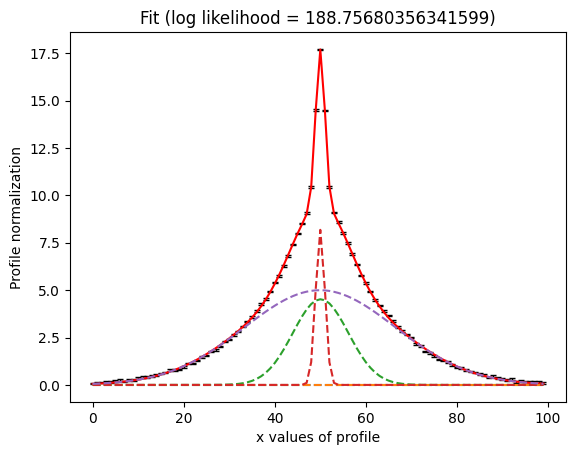

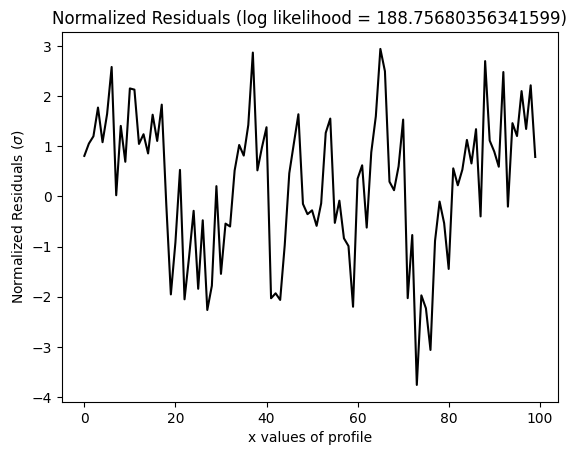

In [17]:
print(result.info)

plt.errorbar(
    x=xvalues,
    y=data,
    yerr=noise_map,
    color="k",
    ecolor="k",
    elinewidth=1,
    capsize=2,
    linestyle="",
)
plt.plot(range(data.shape[0]), model_data, color="r")
for model_data_1d_individual in model_data_list:
    plt.plot(range(data.shape[0]), model_data_1d_individual, "--")
plt.title(f"Fit (log likelihood = {result.log_likelihood})")
plt.xlabel("x values of profile")
plt.ylabel("Profile normalization")
plt.savefig("fit.png")
plt.show()
plt.clf()
plt.close()

residual_map = data - model_data
normalized_residual_map = residual_map / noise_map
plt.plot(xvalues, normalized_residual_map, color="k")
plt.title(f"Normalized Residuals (log likelihood = {result.log_likelihood})")
plt.xlabel("x values of profile")
plt.ylabel("Normalized Residuals ($\sigma$)")
plt.savefig("normalized_residual_map.png")
plt.show()
plt.clf()
plt.close()

Lets consider the advantages and disadvantages of prior tuning:

**Advantages:**

- Higher likelihood of finding the global maximum log likelihood solutions in parameter space.

- Faster search times, as the non-linear search explores less of the parameter space.

**Disadvantages:**

- Incorrectly specified priors could lead the non-linear search to an incorrect solution.

- It is not always clear how the priors should be tuned, especially for complex models.

- Priors tuning must be applied to each dataset fitted. For large datasets, this process would be very time-consuming.

__Reducing Complexity__

The non-linear search may fail because the model is too complex, making its parameter space too difficult to 
sample accurately consistent. To address this, we may be able to simplify the model while ensuring it remains 
realistic enough for our scientific study. By making certain assumptions, we can reduce the number of model 
parameters, thereby lowering the dimensionality of the parameter space and improving the search's performance.

For example, we may know that the `Gaussian`'s in our model are aligned at the same `centre`. We can therefore
compose a model that assumes that the `centre` of each `Gaussian` is the same, reducing the dimensionality of the
model from N=15 to N=11.

The code below shows how we can customize the model components to ensure the `centre` of each `Gaussian` is the same:

In [18]:
gaussian_0 = af.Model(Gaussian)
gaussian_1 = af.Model(Gaussian)
gaussian_2 = af.Model(Gaussian)
gaussian_3 = af.Model(Gaussian)
gaussian_4 = af.Model(Gaussian)

gaussian_1.centre = gaussian_0.centre
gaussian_2.centre = gaussian_0.centre
gaussian_3.centre = gaussian_0.centre
gaussian_4.centre = gaussian_0.centre

model = af.Collection(
    gaussian_0=gaussian_0,
    gaussian_1=gaussian_1,
    gaussian_2=gaussian_2,
    gaussian_3=gaussian_3,
    gaussian_4=gaussian_4,
)

The `info` attribute shows the model is now using the same `centre` for all `Gaussian`'s and has 11 free parameters.

In [19]:
print(model.info)

Total Free Parameters = 11

model                                                                           Collection (N=11)
    gaussian_0 - gaussian_4                                                     Gaussian (N=3)

gaussian_0 - gaussian_4
    centre                                                                      UniformPrior [40], lower_limit = 0.0, upper_limit = 100.0
gaussian_0
    normalization                                                               LogUniformPrior [41], lower_limit = 1e-06, upper_limit = 1000000.0
    sigma                                                                       UniformPrior [42], lower_limit = 0.0, upper_limit = 25.0
gaussian_1
    normalization                                                               LogUniformPrior [44], lower_limit = 1e-06, upper_limit = 1000000.0
    sigma                                                                       UniformPrior [45], lower_limit = 0.0, upper_limit = 25.0
gaussian_2
    normalizati

We now repeat the model-fit using this updated model where the `centre` of each `Gaussian` is the same.

You should again note that the run time of the fit is significantly faster than the previous fits
and that it consistently produces a good model-fit more often. This is because the model is less complex,
non-linear parameter space is less difficult to sample and the search is less likely to converge on a local maxima.

In [20]:
print(
    """
    The non-linear search has begun running.
    This Jupyter notebook cell with progress once the search has completed - this could take a few minutes!
    """
)

result = search.fit(model=model, analysis=analysis)

print("The search has finished run - you may now continue the notebook.")


    The non-linear search has begun running.
    This Jupyter notebook cell with progress once the search has completed - this could take a few minutes!
    
2024-07-16 13:59:56,826 - autofit.non_linear.search.abstract_search - INFO - Starting non-linear search with 1 cores.
2024-07-16 13:59:56,828 - root - INFO - Output to hard-disk disabled, input a search name to enable.
2024-07-16 13:59:56,829 - root - INFO - Starting new Dynesty non-linear search (no previous samples found).
2024-07-16 13:59:56,877 - autofit.non_linear.parallel.sneaky - INFO - Creating pool with 1 processes
2024-07-16 13:59:56,889 - process 0 - INFO - created
2024-07-16 13:59:56,924 - autofit.non_linear.initializer - INFO - Generating initial samples of model using 1 cores
2024-07-16 13:59:57,099 - autofit.non_linear.initializer - INFO - Initial samples generated, starting non-linear search


2810it [00:13, 208.69it/s, +50 | bound: 340 | nc: 1 | ncall: 15023 | eff(%): 19.101 | loglstar:   -inf < 125.753 <    inf | logz: 71.630 +/-  0.848 | dlogz:  0.001 >  0.059]    


2024-07-16 14:00:11,315 - root - INFO - Search complete, returning result
The search has finished run - you may now continue the notebook.


Lets print the result info and plot the fit to the dataset to confirm the reduced model complexity has 
provided a better model-fit.

Bayesian Evidence                                                               71.62981225
Maximum Log Likelihood                                                          125.75275203
Maximum Log Posterior                                                           1439783.84657127

model                                                                           Collection (N=11)
    gaussian_0 - gaussian_4                                                     Gaussian (N=3)

Maximum Log Likelihood Model:

gaussian_0 - gaussian_4
    centre                                                                      49.999
gaussian_0
    normalization                                                               66.752
    sigma                                                                       6.057
gaussian_1
    normalization                                                               0.000
    sigma                                                                       20.212
gaussian_2
  

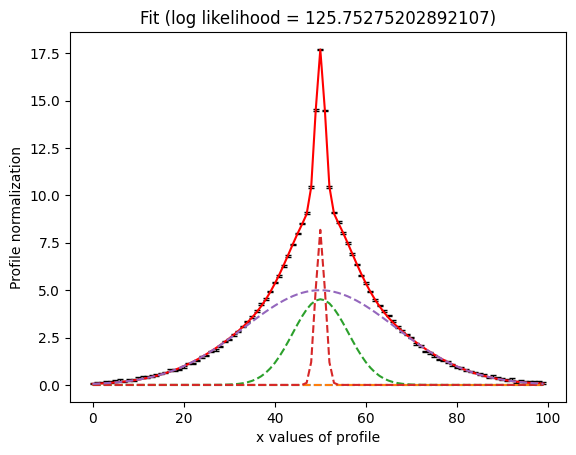

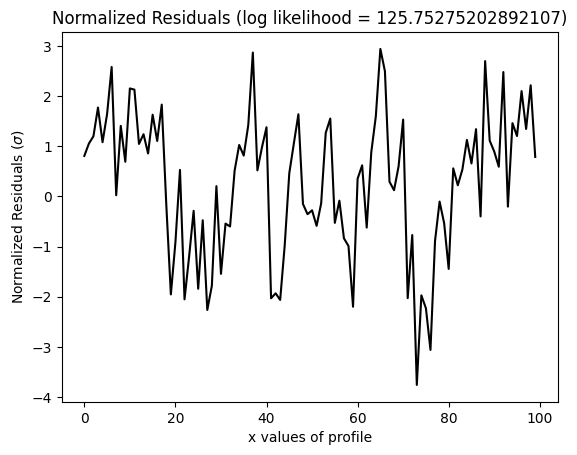

In [21]:
print(result.info)

plt.errorbar(
    x=xvalues,
    y=data,
    yerr=noise_map,
    color="k",
    ecolor="k",
    elinewidth=1,
    capsize=2,
    linestyle="",
)
plt.plot(range(data.shape[0]), model_data, color="r")
for model_data_1d_individual in model_data_list:
    plt.plot(range(data.shape[0]), model_data_1d_individual, "--")
plt.title(f"Fit (log likelihood = {result.log_likelihood})")
plt.xlabel("x values of profile")
plt.ylabel("Profile normalization")
plt.savefig("fit.png")
plt.show()
plt.clf()
plt.close()

residual_map = data - model_data
normalized_residual_map = residual_map / noise_map
plt.plot(xvalues, normalized_residual_map, color="k")
plt.title(f"Normalized Residuals (log likelihood = {result.log_likelihood})")
plt.xlabel("x values of profile")
plt.ylabel("Normalized Residuals ($\sigma$)")
plt.savefig("normalized_residual_map.png")
plt.show()
plt.clf()
plt.close()

Let’s consider the advantages and disadvantages of simplifying the model:

Advantages:

- By reducing the complexity of the parameter space, we increase the chances of finding the global maximum log 
likelihood, and the search requires less time to do so.

- Unlike with tuned priors, this approach is not specific to a single dataset, allowing us to use it on many datasets.

Disadvantages:

- Our model is less realistic, which may negatively impact the accuracy of our fit and the scientific results we
derive from it.

__Search More Thoroughly__

In approaches 1 and 2, we assisted our non-linear search to find the highest log likelihood regions of parameter 
space. In approach 3, we're simply going to tell the search to look more thoroughly through parameter space.

Every non-linear search has settings that control how thoroughly it explores parameter space. For Dynesty, the 
primary setting is the number of live points `nlive`. The more thoroughly the search examines the space, the more 
likely it is to find the global maximum model. However, this also means the search will take longer!

Below, we configure a more thorough Dynesty search with `nlive=500`. It is currently unclear what changing
this setting actually does and what the number of live points actually means. These will be covered in chapter 2
of the **HowToFit** lectures, where we will also expand on how a non-linear search actually works and the different
types of methods that can be used to search parameter space. 

In [22]:
model = af.Collection(
    gaussian_0=Gaussian,
    gaussian_1=Gaussian,
    gaussian_2=Gaussian,
    gaussian_3=Gaussian,
    gaussian_4=Gaussian,
)

The `model.info` confirms the model is the same model fitted initially, composed of 5 `Gaussian` profiles.

In [23]:
print(model.info)

Total Free Parameters = 15

model                                                                           Collection (N=15)
    gaussian_0 - gaussian_4                                                     Gaussian (N=3)

gaussian_0
    centre                                                                      UniformPrior [55], lower_limit = 0.0, upper_limit = 100.0
    normalization                                                               LogUniformPrior [56], lower_limit = 1e-06, upper_limit = 1000000.0
    sigma                                                                       UniformPrior [57], lower_limit = 0.0, upper_limit = 25.0
gaussian_1
    centre                                                                      UniformPrior [58], lower_limit = 0.0, upper_limit = 100.0
    normalization                                                               LogUniformPrior [59], lower_limit = 1e-06, upper_limit = 1000000.0
    sigma                                        

__Search__

We again use the nested sampling algorithm Dynesty to fit the model to the data, but now increase the number of live 
points to 300 meaning it will search parameter space more thoroughly.

In [24]:
search = af.DynestyStatic(
    nlive=300,
    sample="rwalk",  # This makes dynesty run faster, don't worry about what it means for now!
)

__Model Fit__

Perform the fit using our five `Gaussian` model, which has 15 free parameters. 

In [25]:
analysis = Analysis(data=data, noise_map=noise_map)

print(
    """
    The non-linear search has begun running.
    This Jupyter notebook cell with progress once the search has completed - this could take a few minutes!
    """
)

result = search.fit(model=model, analysis=analysis)

print("The search has finished run - you may now continue the notebook.")



    The non-linear search has begun running.
    This Jupyter notebook cell with progress once the search has completed - this could take a few minutes!
    
2024-07-16 14:00:11,986 - autofit.non_linear.search.abstract_search - INFO - Starting non-linear search with 1 cores.
2024-07-16 14:00:11,988 - root - INFO - Output to hard-disk disabled, input a search name to enable.
2024-07-16 14:00:11,988 - root - INFO - Starting new Dynesty non-linear search (no previous samples found).
2024-07-16 14:00:12,041 - autofit.non_linear.parallel.sneaky - INFO - Creating pool with 1 processes
2024-07-16 14:00:12,054 - process 0 - INFO - created
2024-07-16 14:00:12,092 - autofit.non_linear.initializer - INFO - Generating initial samples of model using 1 cores
2024-07-16 14:00:13,463 - autofit.non_linear.initializer - INFO - Initial samples generated, starting non-linear search


47968it [04:38, 172.10it/s, +300 | bound: 1064 | nc: 1 | ncall: 245679 | eff(%): 19.671 | loglstar:   -inf < 155.616 <    inf | logz: -4.127 +/-  0.675 | dlogz:  0.001 >  0.309]  


2024-07-16 14:05:10,943 - root - INFO - Search complete, returning result
The search has finished run - you may now continue the notebook.


Lets print the result info and plot the fit to the dataset to confirm the more thorough search has provided a better
model-fit.

Bayesian Evidence                                                               -4.12684324
Maximum Log Likelihood                                                          155.61582615
Maximum Log Posterior                                                           1365724.00030434

model                                                                           Collection (N=15)
    gaussian_0 - gaussian_4                                                     Gaussian (N=3)

Maximum Log Likelihood Model:

gaussian_0
    centre                                                                      77.073
    normalization                                                               9.604
    sigma                                                                       12.113
gaussian_1
    centre                                                                      50.294
    normalization                                                               77.692
    sigma                           

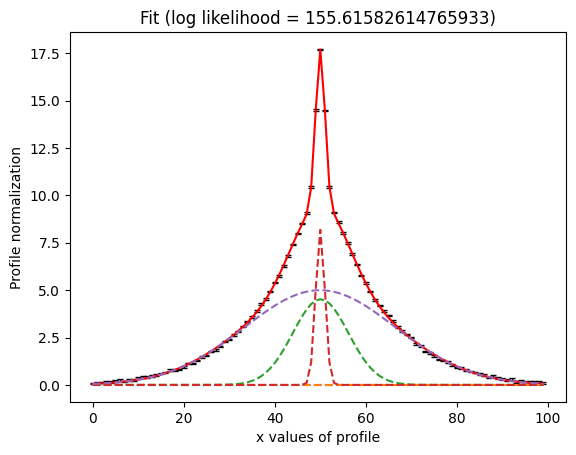

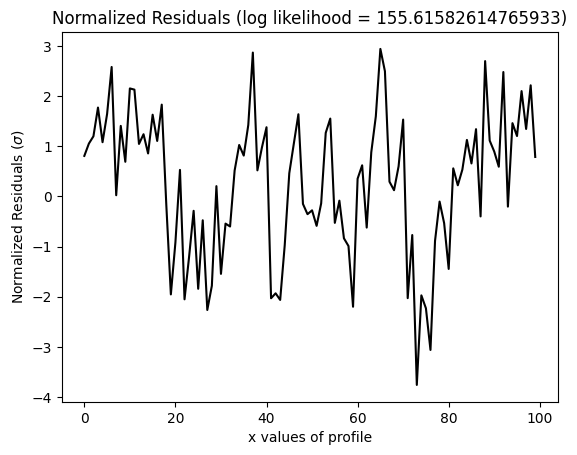

In [26]:
print(result.info)

plt.errorbar(
    x=xvalues,
    y=data,
    yerr=noise_map,
    color="k",
    ecolor="k",
    elinewidth=1,
    capsize=2,
    linestyle="",
)
plt.plot(range(data.shape[0]), model_data, color="r")
for model_data_1d_individual in model_data_list:
    plt.plot(range(data.shape[0]), model_data_1d_individual, "--")
plt.title(f"Fit (log likelihood = {result.log_likelihood})")
plt.xlabel("x values of profile")
plt.ylabel("Profile normalization")
plt.savefig("fit.png")
plt.show()
plt.clf()
plt.close()

residual_map = data - model_data
normalized_residual_map = residual_map / noise_map
plt.plot(xvalues, normalized_residual_map, color="k")
plt.title(f"Normalized Residuals (log likelihood = {result.log_likelihood})")
plt.xlabel("x values of profile")
plt.ylabel("Normalized Residuals ($\sigma$)")
plt.savefig("normalized_residual_map.png")
plt.show()
plt.clf()
plt.close()

If you repeat the fit multiple times, you will find that the model-fit is more likely to produce a good fit than
previously. 

However, the run-time of the search is noticeably longer, taking a few minutes to complete, owining
to the increased number of live points and fact it is searching parameter space more thoroughly.

Let's list the advantages and disadvantages of simply adjusting the non-linear search:

**Advantages:**

- It’s easy to set up; just change the settings of the non-linear search.

- It generalizes to any dataset.

- We can retain a more complex model.

**Disadvantage:**

- It can be very expensive in terms of run time, producing run-times that are five, tens or even longer than the
  original run-time.

__Summary__

We have covered three strategies for ensuring the non-linear search estimates the correct solution:

1) Prior Tuning: By setting our priors more accurately, we can help the search find the global solution instead of
    getting stuck at a local maxima.
    
2) Reducing Complexity: By making certain assumptions, we can reduce the number of model parameters, thereby lowering
    the dimensionality of the parameter space and improving the search's performance.
    
3) Search More Thoroughly: By increasing the number of live points, we can make the search explore parameter space
    more thoroughly, increasing the likelihood of finding the global maximum model.
    
Each of these strategies has its advantages and disadvantages, and your ability to fit models successfully will
likely rely on a combination of these strategies. Which one works best depends on the specific model, dataset and
scientific question you are trying to answer. Therefore, when you begin your own model-fitting, it is a good idea to
try each of these strategies and assess which works best for your model-fit.

__Run Times__

One challenging aspect of model-fitting which was not properly covered in this tutorial is the run-time of a model-fit.
This example fits simple 1D datasets, which are computationally inexpensive to fit. That is, the `log_likelihood_function`
is evaluated in a fraction of a second, meaning the non-linear search fitted the model in mere minutes.

Many model-fitting tasks are not as fast. For example, when fitting a model to a 2D image, the `log_likelihood_function`
may take of order seconds, or longer, because it comprises a number of expensive calculations (e.g. a Fourier transform,
2D convolution, etc.). Depending on the model complexity, this means that the non-linear search may take hours, days 
or even weeks to fit the model.

Run times are also dictated by the complexity of the model and the nature of the log likelihood function. For models
with many more dimensions than the simple 1D model used in this tutorial (e.g. hundreds or thousands of free parameters),
non-linear search may take tens or hundreds of more iterations to converge on a solution. This is because the parameter
space is significantly more complex and difficult to sample accurately. More iterations mean longer run times,
which in combination with a slow likelihood function can make model-fitting infeasible.

Whether or not run times will pose a challenge to your model-fitting task depends on the complexity of the model and
nature of the log likelihood function. If your problem is computationally expensive, **PyAutoFit** provides many
tools to help, which will be the topic of tutorials in chapter 2 of the **HowToFit** lectures. 

**PyAutoFit** provides tools to profile the run-time of your log likelihood function, which can be used to
assess the computational expense of your model-fit and plan accordingly. Below is an example of the simplest use
of these tools, an estimate of the run-time of the log likelihood function using one random instance of the model.


Feature still being developed, IGNORE FOR NOW.

run_time_dict, info_dict = analysis.profile_log_likelihood_function(
    instance=model.random_instance()
)
print(f"Log Likelihood Evaluation Time (second) = {run_time_dict['fit_time']}")

__Model Mismatch__

In this example, interpreting how well the model fitted the data, and whether it found the global maxima, was
relatively straightforward. This is because the same model was used to simulate the data and fit it, meaning the 
global maxima fit corresponded to one where the normalized residuals were minimized and consistent with the noise
(e.g. they went to sigma values below 3.0 or so).

In many scientific studies, the data that one is fitting may have come from an instrument or simulation where the
exact physical processes that generate the data are not perfectly known. This then means that the model is
not a perfect representation of the data, and it may not ever be possible to fit the data perfectly. In this case,
we might infer a fit with significant residuals, but it may still correspond to the global maxima solution,
at least for that particular model.

This makes it even more difficult to be certain if the non-linear search is sampling parameter space correctly,
and therefore requires even more care and attention to the strategies we have discussed above.

Whether or not this is the case for your model-fitting task is something you will have to determine yourself. 
**PyAutoFit** provides many tools to help assess the quality of a model-fit, which will be the topic of tutorials
in chapter 2 of the **HowToFit** lectures.

__Astronomy Example__

At the end of chapter 1, we will fit a complex model to a real astronomical dataset in order to quantify
the distribution of stars in 2D images of galaxies.

This example will illustrate many of the challenges discussed in this tutorial, including:

- Fits using more complex models consisting of 15-20 parameters often infer local maxima, unless we assist the
  non-linear search with tuned priors, reduced complexity or a more thorough search.

- Fitting 2D imaging data requires a 2D convolution, which is somewhat computationally expensive and means run times
  become something we must balance with model complexity.

- The model is not a perfect representation of the data. For example, the model assumes the galaxy is elliptically
  symmetric, whereas the real galaxy may not be. In certain examples, this means that the global maxima solution
  actually leaves significant residuals, above 3.0 $\sigma$, in the data.

__Wrap Up__

Now is a good time to assess how straightforward or difficult you think your model-fitting task will be. 

Are the models you will be fitting made up of tens of parameters? or thousands? Are there ways you can simplify
the model parameter or tune priors to make the model-fitting task more feasible? Will run times be an issue, or is
your likelihood function computationally cheap? And how confident are you that the model you are fitting is a good
representation of the data?

These are all questions you should be asking yourself before beginning your model-fitting task, but they will
become easier to answer as you gain experience with model-fitting and **PyAutoFit**.